Original Audio:


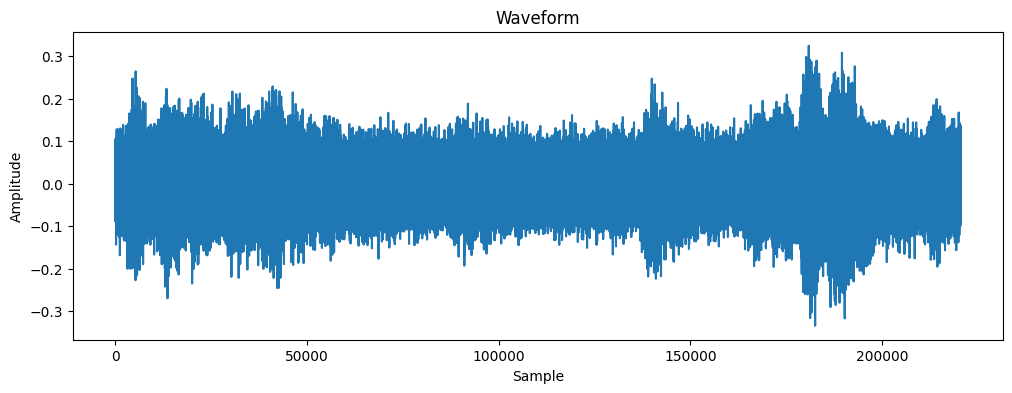

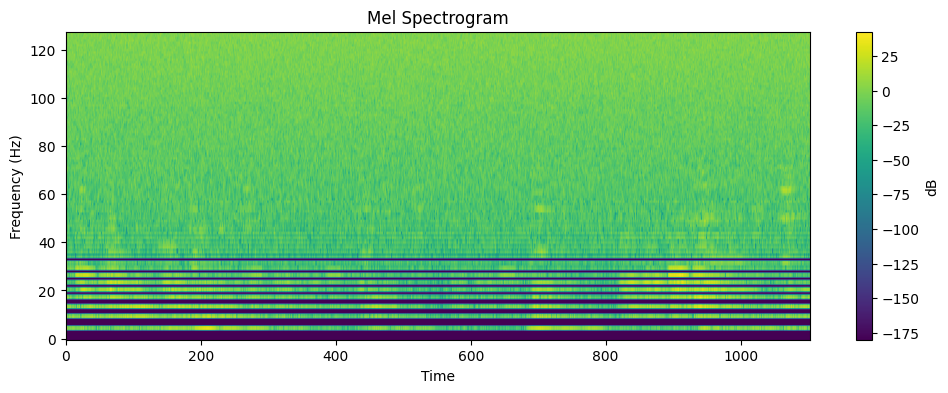

Classifier Result: Noisy


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Audio loaded with shape: (87892,), duration: 5.49 seconds
No sufficiently long silent gap found.
No silent gap detected. Returning original audio.
Final Audio:


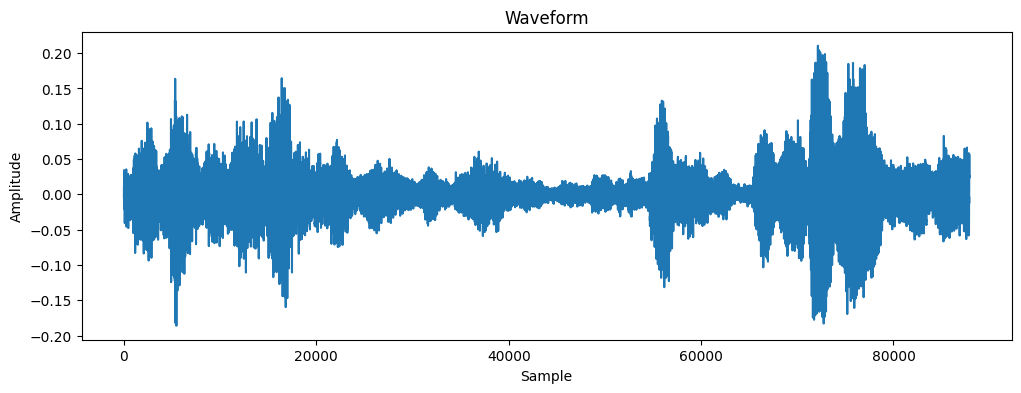

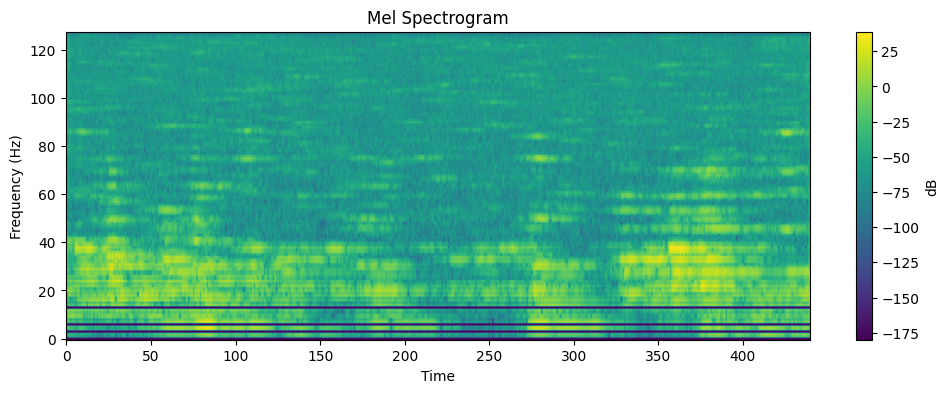

Original Audio:


Final Processed Audio:


In [16]:
import torchaudio
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import torch
from tensorflow.keras.models import load_model
import numpy as np
import librosa
import soundfile as sf
import cv2
import os
from scipy.signal import lfiltic, lfilter
from spectrum.burg import _arburg2


#Spectrogram Classifier
class SpectrogramClassifier(torch.nn.Module):
    def __init__(self, num_classes=2):
        super(SpectrogramClassifier, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.3)
        self.fc2 = torch.nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        in_features = x.size(1)
        self.fc1 = torch.nn.Linear(in_features, 128)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


def predict_audio(audio_path, model_path, device='cuda'):
    model = SpectrogramClassifier(num_classes=2)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = SpectrogramClassifier(num_classes=2)
    map_location = device
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True), strict=False)
    model.to(device)
    model.eval()

    sample_rate = 44100
    n_mels = 64
    waveform, sr = torchaudio.load(audio_path)

    if sr != sample_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=sample_rate)
        waveform = resampler(waveform)

    mel_spec = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=2048,
        hop_length=512,
        n_mels=64 
    )(waveform)

    mel_spec = mel_spec.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(mel_spec)
        _, predicted = torch.max(outputs, 1)

    label = "Noisy" if predicted.item() == 1 else "Clean"
    return label


#Denoiser
class MeanVarianceNorm:
    def fit(self, data_to_fit):
        self.mean = np.mean(data_to_fit)
        self.std = np.std(data_to_fit)

    def normalize(self, data_to_transform):
        return (data_to_transform - self.mean) / self.std

    def denormalize(self, data_to_transform):
        return (data_to_transform * self.std) + self.mean


def predict_denoise_audio(noisy_audio_filepath, autoencoder, sample_rate=16000, duration_s=5):
    data, _ = librosa.load(noisy_audio_filepath, sr=sample_rate)
    duration = int(sample_rate * duration_s)

    if len(data) < duration:
        data = np.pad(data, (0, duration - len(data)), 'constant')
    elif len(data) > duration:
        data = data[:duration]

    S_noisy = np.abs(librosa.stft(data, n_fft=2048))[:-1, :]
    S_noisy_resized = cv2.resize(S_noisy, (173, 1024)).T
    N = MeanVarianceNorm()
    N.fit(S_noisy_resized)
    S_noisy_n = N.normalize(S_noisy_resized)

    S_noisy_n = np.expand_dims(S_noisy_n.T, axis=-1)
    S_noisy_n = np.expand_dims(S_noisy_n, axis=0)

    predicted_S_clean_n = autoencoder.predict(S_noisy_n)
    predicted_S_clean = N.denormalize(predicted_S_clean_n[0])

    S_noisy_phase = np.angle(librosa.stft(data, n_fft=2048))[:-1, :]
    S_noisy_phase_resized = cv2.resize(S_noisy_phase, (173, S_noisy_phase.shape[0])).T
    S_noisy_phase_resized = S_noisy_phase_resized.T

    S_clean_complex = predicted_S_clean.squeeze() * np.exp(1j * S_noisy_phase_resized)
    data_clean_inv = librosa.istft(S_clean_complex)

    output_path = 'denoised_audio.wav'
    sf.write(output_path, data_clean_inv, sample_rate)
    return output_path


# Audio Inpainting
def inpaint_audio(audio_path, sr, lpc_order, silence_duration_ms=200, threshold=1e-4):
    def detect_silent_gap(audio, sr, silence_duration_ms=200, threshold=0.001):
        silence_samples = int((silence_duration_ms / 1000) * sr)
        abs_audio = np.abs(audio)

        for i in range(len(audio) - silence_samples):
            window = abs_audio[i : i + silence_samples]
            if np.mean(window) < threshold:
                gap_start = i
                gap_end = i + silence_samples
                return gap_start, gap_end

        print("No sufficiently long silent gap found.")
        return None
    
    def inpaint_audio_with_lpc(audio, gap_start, gap_end, lpc_order):
        context_size = 3000  
        previous_sig = audio[max(0, gap_start - context_size) : gap_start]
        next_sig = audio[gap_end : min(len(audio), gap_end + context_size)]

        if len(previous_sig) == 0 or len(next_sig) == 0:
            print("Insufficient context for LPC-based inpainting.")
            return audio

        lpc_signal = LPC(previous_sig, next_sig, gap_start, gap_end, lpc_order)
        audio[gap_start:gap_end] = np.real(lpc_signal)
        return audio
    
    def LPC(previous_sig, next_sig, gap_start, gap_end, lpc_order):
        target_length = gap_end - gap_start

        ab, _, _ = _arburg2(previous_sig, lpc_order)
        Zb = lfiltic(b=[1], a=ab, y=previous_sig[:-lpc_order-1:-1])
        forw_pred, _ = lfilter(b=[1], a=ab, x=np.zeros((target_length)), zi=Zb)

        next_sig = np.flipud(next_sig)
        af, _, _ = _arburg2(next_sig, lpc_order)
        Zf = lfiltic([1], af, next_sig[:-lpc_order-1:-1])
        backw_pred, _ = lfilter([1], af, np.zeros((target_length)), zi=Zf)
        backw_pred = np.flipud(backw_pred)

        t = np.linspace(0, np.pi/2, target_length)
        sqCos = np.cos(t)**2
        sigout = sqCos * forw_pred + np.flipud(sqCos) * backw_pred
        return sigout

    
    audio, file_sr = torchaudio.load(audio_path)
    audio = audio.squeeze().numpy()

    if file_sr != sr:
        resampler = torchaudio.transforms.Resample(orig_freq=file_sr, new_freq=sr)
        audio = resampler(torch.tensor(audio)).numpy()

    print(f"Audio loaded with shape: {audio.shape}, duration: {len(audio) / sr:.2f} seconds")
    gap = detect_silent_gap(audio, sr, silence_duration_ms, threshold)
    if gap is None:
        print("No silent gap detected. Returning original audio.")
        return audio_path

    gap_start, gap_end = gap
    print(f"Detected silent gap from {gap_start} to {gap_end} samples.")

    inpainted_audio = inpaint_audio_with_lpc(audio, gap_start, gap_end, lpc_order)
    print("Inpainting completed.")
    inpainted_audio_path = audio_path.replace(".wav", "_inpainted.wav")
    sf.write(inpainted_audio_path, inpainted_audio, sr)
    print(f"Inpainted audio saved to: {inpainted_audio_path}")

    return inpainted_audio_path



def plot_waveform_and_spectrogram(audio_path):
    waveform, sr = torchaudio.load(audio_path)
    if waveform.ndim > 1:  
        waveform = waveform.mean(dim=0)
    
    # Plot waveform
    plt.figure(figsize=(12, 4))
    plt.plot(waveform.numpy())
    plt.title("Waveform")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.show()
    
    # Compute and plot spectrogram
    mel_spec = torchaudio.transforms.MelSpectrogram(sample_rate=sr)(waveform)
    plt.figure(figsize=(12, 4))
    plt.imshow(20 * np.log10(mel_spec.numpy() + 1e-9), aspect='auto', origin='lower')
    plt.title("Mel Spectrogram")
    plt.xlabel("Time")
    plt.ylabel("Frequency (Hz)")
    plt.colorbar(label="dB")
    plt.show()


# Full Pipeline
def process_audio_pipeline(audio_path, classifier_model_path, autoencoder, sr=44100, lpc_order=600):
    print("Original Audio:")
    plot_waveform_and_spectrogram(audio_path)
    label = predict_audio(audio_path, classifier_model_path)
    print(f"Classifier Result: {label}")
    audio_path1=audio_path
    if label == "Noisy":
        audio_path1 = predict_denoise_audio(audio_path, autoencoder)
        inpainted_audio_path = inpaint_audio(audio_path1, 16000, lpc_order)
    else:
        inpainted_audio_path = inpaint_audio(audio_path1, sr, lpc_order)
    print("Final Audio:")
    plot_waveform_and_spectrogram(inpainted_audio_path)
    return audio_path, inpainted_audio_path


if __name__ == "__main__":
    classifier_model_path = "/Users/johannasmriti/Downloads/Final working model/classifier/class-epoch-8.pth"
    autoencoder = load_model("/Users/johannasmriti/Downloads/Final working model/denoiser/denoisingAudio5sec2.h5")
    input_audio_path ="/Users/johannasmriti/Downloads/musicnet/Denoising_Audio/noise_data_noisy/1728_part5.wav"
    original_audio, final_audio = process_audio_pipeline(input_audio_path, classifier_model_path, autoencoder)

    print("Original Audio:")
    display(Audio(original_audio, rate=44100))

    print("Final Processed Audio:")
    display(Audio(final_audio, rate=44100))



Original Audio:


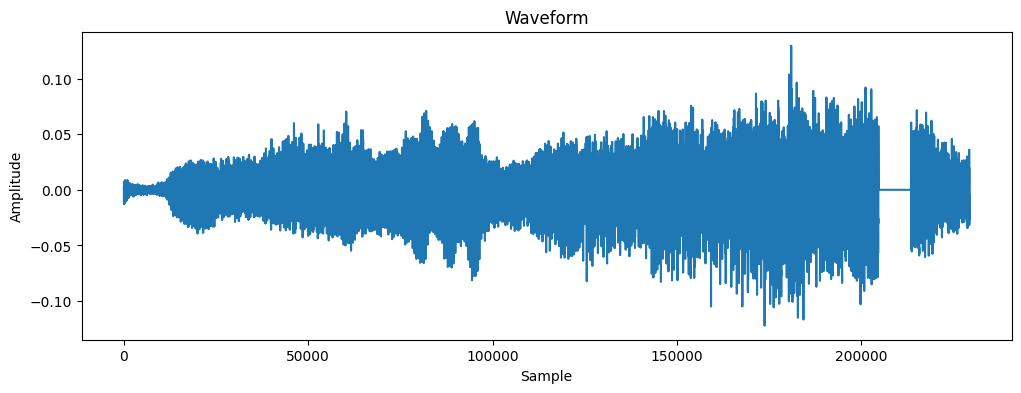

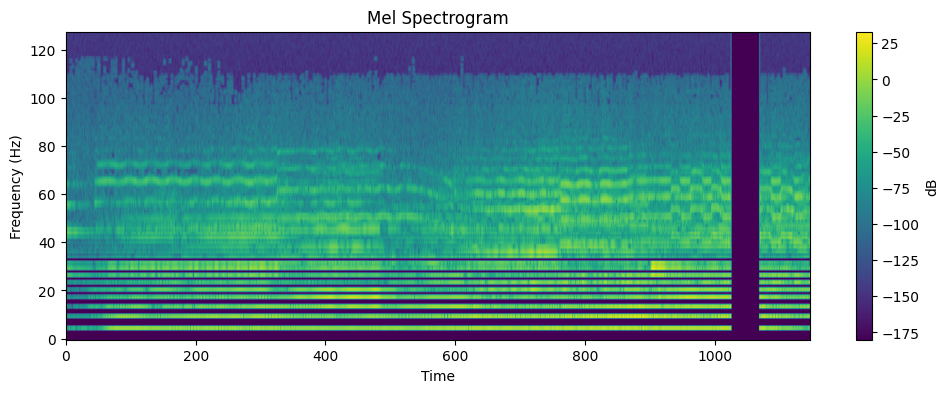

Classifier Result: Clean
Audio loaded with shape: (229317,), duration: 5.20 seconds
Detected silent gap from 204641 to 213461 samples.
Inpainting completed.
Inpainted audio saved to: /Users/johannasmriti/Downloads/musicnet/data_with_gaps/1727_part11_inpainted.wav
Final Audio:


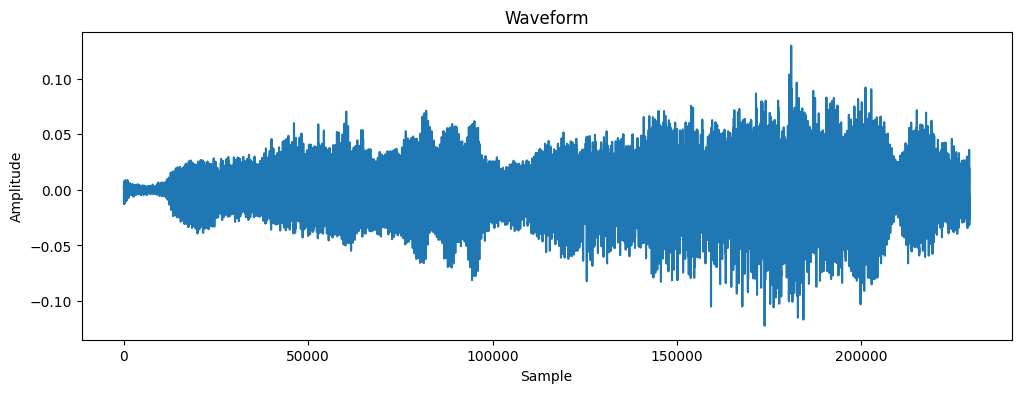

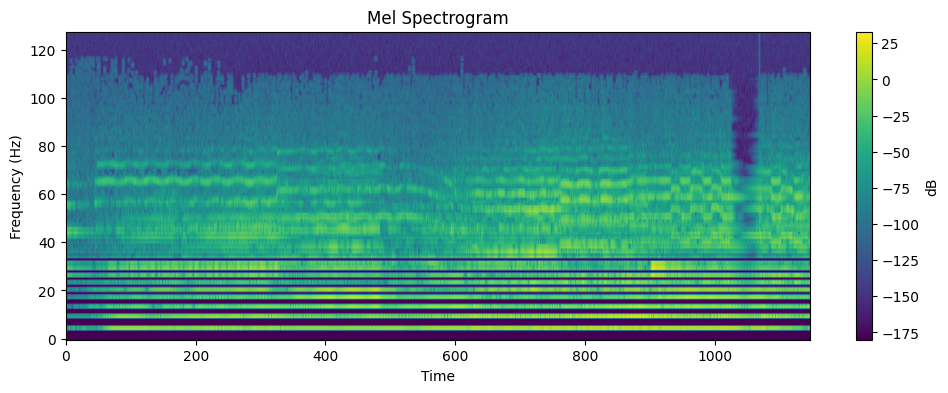

Original Audio:


Final Processed Audio:


In [15]:
import torchaudio
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import torch
from tensorflow.keras.models import load_model
import numpy as np
import librosa
import soundfile as sf
import cv2
import os
from scipy.signal import lfiltic, lfilter
from spectrum.burg import _arburg2


#Spectrogram Classifier
class SpectrogramClassifier(torch.nn.Module):
    def __init__(self, num_classes=2):
        super(SpectrogramClassifier, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.3)
        self.fc2 = torch.nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        in_features = x.size(1)
        self.fc1 = torch.nn.Linear(in_features, 128)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


def predict_audio(audio_path, model_path, device='cuda'):
    model = SpectrogramClassifier(num_classes=2)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = SpectrogramClassifier(num_classes=2)
    map_location = device
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True), strict=False)
    model.to(device)
    model.eval()

    sample_rate = 44100
    n_mels = 64
    waveform, sr = torchaudio.load(audio_path)

    if sr != sample_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=sample_rate)
        waveform = resampler(waveform)

    mel_spec = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=2048,
        hop_length=512,
        n_mels=64  
    )(waveform)

    mel_spec = mel_spec.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(mel_spec)
        _, predicted = torch.max(outputs, 1)

    label = "Noisy" if predicted.item() == 1 else "Clean"
    return label


#Denoiser
class MeanVarianceNorm:
    def fit(self, data_to_fit):
        self.mean = np.mean(data_to_fit)
        self.std = np.std(data_to_fit)

    def normalize(self, data_to_transform):
        return (data_to_transform - self.mean) / self.std

    def denormalize(self, data_to_transform):
        return (data_to_transform * self.std) + self.mean


def predict_denoise_audio(noisy_audio_filepath, autoencoder, sample_rate=16000, duration_s=5):
    data, _ = librosa.load(noisy_audio_filepath, sr=sample_rate)
    duration = int(sample_rate * duration_s)

    if len(data) < duration:
        data = np.pad(data, (0, duration - len(data)), 'constant')
    elif len(data) > duration:
        data = data[:duration]

    S_noisy = np.abs(librosa.stft(data, n_fft=2048))[:-1, :]
    S_noisy_resized = cv2.resize(S_noisy, (173, 1024)).T
    N = MeanVarianceNorm()
    N.fit(S_noisy_resized)
    S_noisy_n = N.normalize(S_noisy_resized)

    S_noisy_n = np.expand_dims(S_noisy_n.T, axis=-1)
    S_noisy_n = np.expand_dims(S_noisy_n, axis=0)

    predicted_S_clean_n = autoencoder.predict(S_noisy_n)
    predicted_S_clean = N.denormalize(predicted_S_clean_n[0])

    S_noisy_phase = np.angle(librosa.stft(data, n_fft=2048))[:-1, :]
    S_noisy_phase_resized = cv2.resize(S_noisy_phase, (173, S_noisy_phase.shape[0])).T
    S_noisy_phase_resized = S_noisy_phase_resized.T

    S_clean_complex = predicted_S_clean.squeeze() * np.exp(1j * S_noisy_phase_resized)
    data_clean_inv = librosa.istft(S_clean_complex)

    output_path = 'denoised_audio.wav'
    sf.write(output_path, data_clean_inv, sample_rate)
    return output_path


# Audio Inpainting
def inpaint_audio(audio_path, sr, lpc_order, silence_duration_ms=200, threshold=1e-4):
    def detect_silent_gap(audio, sr, silence_duration_ms=200, threshold=0.001):
        silence_samples = int((silence_duration_ms / 1000) * sr)
        abs_audio = np.abs(audio)

        for i in range(len(audio) - silence_samples):
            window = abs_audio[i : i + silence_samples]
            if np.mean(window) < threshold:
                gap_start = i
                gap_end = i + silence_samples
                return gap_start, gap_end

        print("No sufficiently long silent gap found.")
        return None
    
    def inpaint_audio_with_lpc(audio, gap_start, gap_end, lpc_order):
        context_size = 3000  
        previous_sig = audio[max(0, gap_start - context_size) : gap_start]
        next_sig = audio[gap_end : min(len(audio), gap_end + context_size)]

        if len(previous_sig) == 0 or len(next_sig) == 0:
            print("Insufficient context for LPC-based inpainting.")
            return audio

        lpc_signal = LPC(previous_sig, next_sig, gap_start, gap_end, lpc_order)
        audio[gap_start:gap_end] = np.real(lpc_signal)
        return audio
    
    def LPC(previous_sig, next_sig, gap_start, gap_end, lpc_order):
        target_length = gap_end - gap_start

        ab, _, _ = _arburg2(previous_sig, lpc_order)
        Zb = lfiltic(b=[1], a=ab, y=previous_sig[:-lpc_order-1:-1])
        forw_pred, _ = lfilter(b=[1], a=ab, x=np.zeros((target_length)), zi=Zb)

        next_sig = np.flipud(next_sig)
        af, _, _ = _arburg2(next_sig, lpc_order)
        Zf = lfiltic([1], af, next_sig[:-lpc_order-1:-1])
        backw_pred, _ = lfilter([1], af, np.zeros((target_length)), zi=Zf)
        backw_pred = np.flipud(backw_pred)

        t = np.linspace(0, np.pi/2, target_length)
        sqCos = np.cos(t)**2
        sigout = sqCos * forw_pred + np.flipud(sqCos) * backw_pred
        return sigout
    
    audio, file_sr = torchaudio.load(audio_path)
    audio = audio.squeeze().numpy()

    if file_sr != sr:
        
        resampler = torchaudio.transforms.Resample(orig_freq=file_sr, new_freq=sr)
        audio = resampler(torch.tensor(audio)).numpy()

    print(f"Audio loaded with shape: {audio.shape}, duration: {len(audio) / sr:.2f} seconds")
    
    gap = detect_silent_gap(audio, sr, silence_duration_ms, threshold)
    if gap is None:
        print("No silent gap detected. Returning original audio.")
        return audio_path

    gap_start, gap_end = gap
    print(f"Detected silent gap from {gap_start} to {gap_end} samples.")
    
    inpainted_audio = inpaint_audio_with_lpc(audio, gap_start, gap_end, lpc_order)
    print("Inpainting completed.")
    inpainted_audio_path = audio_path.replace(".wav", "_inpainted.wav")
    sf.write(inpainted_audio_path, inpainted_audio, sr)
    print(f"Inpainted audio saved to: {inpainted_audio_path}")

    return inpainted_audio_path



def plot_waveform_and_spectrogram(audio_path):
    waveform, sr = torchaudio.load(audio_path)
    if waveform.ndim > 1:  
        waveform = waveform.mean(dim=0)
    
    # Plot waveform
    plt.figure(figsize=(12, 4))
    plt.plot(waveform.numpy())
    plt.title("Waveform")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.show()
    
    # Compute and plot spectrogram
    mel_spec = torchaudio.transforms.MelSpectrogram(sample_rate=sr)(waveform)
    plt.figure(figsize=(12, 4))
    plt.imshow(20 * np.log10(mel_spec.numpy() + 1e-9), aspect='auto', origin='lower')
    plt.title("Mel Spectrogram")
    plt.xlabel("Time")
    plt.ylabel("Frequency (Hz)")
    plt.colorbar(label="dB")
    plt.show()


# Full Pipeline
def process_audio_pipeline(audio_path, classifier_model_path, autoencoder, sr=44100, lpc_order=600):
    print("Original Audio:")
    plot_waveform_and_spectrogram(audio_path)
    label = predict_audio(audio_path, classifier_model_path)
    print(f"Classifier Result: {label}")
    audio_path1=audio_path
    if label == "Noisy":
        audio_path1 = predict_denoise_audio(audio_path, autoencoder)
        inpainted_audio_path = inpaint_audio(audio_path1, 16000, lpc_order)
    else:
        inpainted_audio_path = inpaint_audio(audio_path1, sr, lpc_order)
    print("Final Audio:")
    plot_waveform_and_spectrogram(inpainted_audio_path)
    return audio_path, inpainted_audio_path


if __name__ == "__main__":
    classifier_model_path = "/Users/johannasmriti/Downloads/Final working model/classifier/class-epoch-8.pth"
    autoencoder = load_model("/Users/johannasmriti/Downloads/Final working model/denoiser/denoisingAudio5sec2.h5")
    input_audio_path ="/Users/johannasmriti/Downloads/musicnet/data_with_gaps/1727_part11.wav"
    original_audio, final_audio = process_audio_pipeline(input_audio_path, classifier_model_path, autoencoder)

    print("Original Audio:")
    display(Audio(original_audio, rate=44100))

    print("Final Processed Audio:")
    display(Audio(final_audio, rate=44100))

